# Reinforcement Learning with Novelty seeking for modeling human behavior

In [1]:
import gym
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
np.__version__

'1.26.4'

In [3]:
gym.__version__

'0.25.2'

# Пример агентов, получающих награду за исследование нового

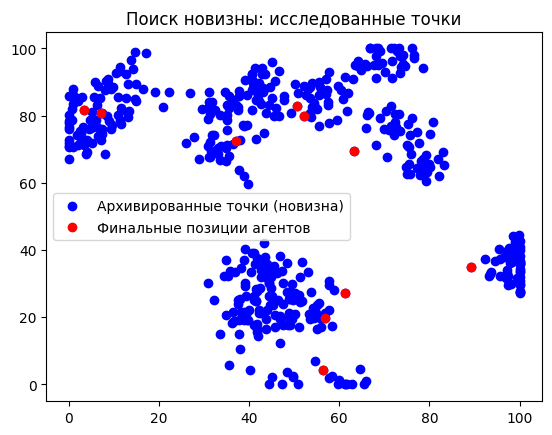

In [9]:
# Определение области поиска
SPACE_SIZE = 100  # Размер пространства
NUM_AGENTS = 10  # Количество агентов
STEPS = 50  # Количество шагов для обучения
NOVELTY_THRESHOLD = 5  # Минимальная "новизна" для вознаграждения

# Функция для расчета расстояния между двумя точками
def distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

# Функция для расчета "новизны" точки (на основе расстояния до прошлых состояний)
def calculate_novelty(position, archive):
    distances = [distance(position, past_position) for past_position in archive]
    if len(distances) == 0:
        return float('inf')  # Если архив пустой, это всегда новая точка
    return np.mean(distances)  # Новизна — среднее расстояние до всех пройденных точек

# Инициализация агентов и архива
agents = [np.random.uniform(0, SPACE_SIZE, size=(2,)) for _ in range(NUM_AGENTS)]
archive = []  # Архив для хранения уже посещенных точек

# Основной цикл обучения
for step in range(STEPS):

    # Для каждого агента: переместиться и оценить новизну
    for i, agent in enumerate(agents):
        # Генерация случайного перемещения агента
        move = np.random.uniform(-5, 5, size=(2,))
        new_position = np.clip(agent + move, 0, SPACE_SIZE)  # Убедимся, что остаемся в пределах пространства

        # Оценка новизны нового положения
        novelty = calculate_novelty(new_position, archive)

        # Если точка достаточно новая, сохраняем её в архив
        if novelty > NOVELTY_THRESHOLD:
            archive.append(new_position)

        # Обновляем положение агента
        agents[i] = new_position

# Визуализация
archive = np.array(archive)
agents = np.array(agents)
plt.scatter(archive[:, 0], archive[:, 1], c="blue", label="Архивированные точки (новизна)")
plt.scatter(agents[:, 0], agents[:, 1], c="red", label="Финальные позиции агентов")
plt.title("Поиск новизны: исследованные точки")
plt.legend()
plt.show()


# Пример в котором агенты исследуют новое для поиска награды

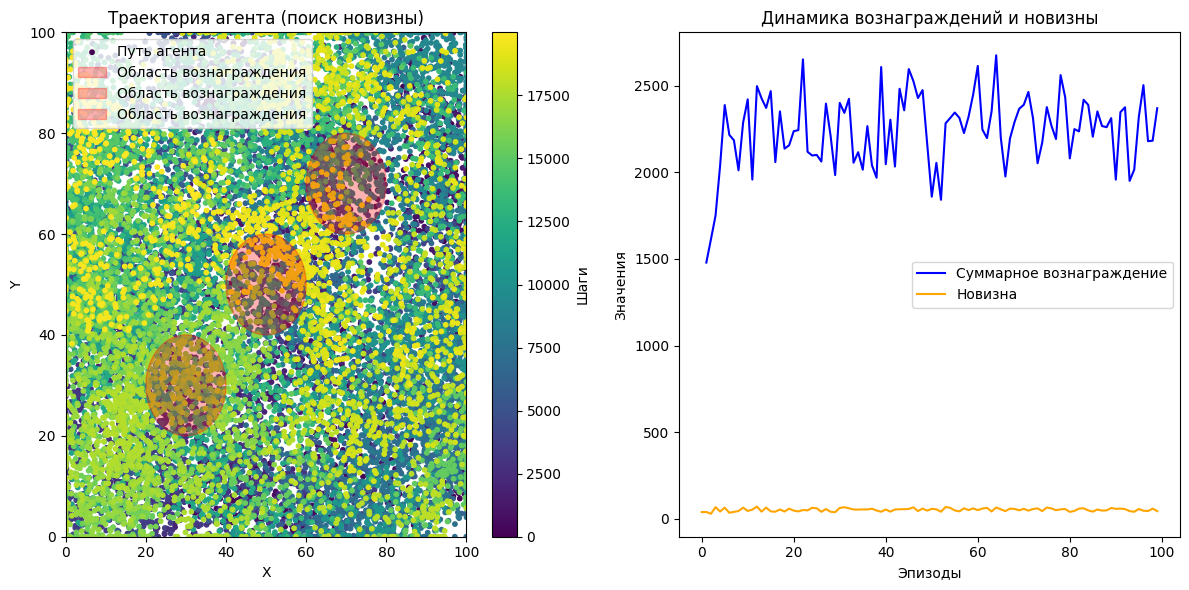

In [10]:
# Параметры среды
SPACE_SIZE = 100  # Размер двумерного пространства
NUM_EPISODES = 100  # Количество эпизодов
STEPS_PER_EPISODE = 200  # Количество шагов за эпизод
NOVELTY_WEIGHT = 0.2  # Вес для поощрения новизны
REWARD_ZONES = [(30, 30), (70, 70), (50, 50)]  # Области с вознаграждением

# Помощники
def euclidean_distance(a, b):
    """Евклидово расстояние между двумя точками"""
    return np.linalg.norm(np.array(a) - np.array(b))

def calculate_novelty(position, archive):
    """Оценка новизны текущей позиции"""
    if len(archive) == 0:
        return float('inf')  # Если архив пуст
    distances = [euclidean_distance(position, past_position) for past_position in archive]
    return np.mean(distances)

def calculate_reward(position):
    """Внешнее вознаграждение на основе нахождения в области с вознаграждением"""
    for reward_zone in REWARD_ZONES:
        if euclidean_distance(position, reward_zone) < 10:  # Радиус вознаграждения = 10
            return 10.0
    return -0.1  # Малое отрицательное вознаграждение за каждое действие

# Инициализация агента
class Agent:
    """Агент, перемещающийся по двумерному пространству"""
    def __init__(self):
        self.position = np.random.uniform(0, SPACE_SIZE, size=(2,))  # Случайное начальное положение
        self.archive = []  # Архив местоположений
        self.positions = []  # Для визуализации пути агента

    def move(self):
        """Случайное перемещение в пределах пространства"""
        move = np.random.uniform(-5, 5, size=(2,))
        new_position = np.clip(self.position + move, 0, SPACE_SIZE)
        self.position = new_position
        self.positions.append(new_position)

    def update_archive(self):
        """Добавить текущее состояние в архив"""
        self.archive.append(self.position)

# Основной цикл обучения
def train_agent():
    agent = Agent()
    rewards_history = []
    novelty_history = []

    for episode in range(NUM_EPISODES):
        total_reward = 0

        for step in range(STEPS_PER_EPISODE):
            # Агент делает шаг
            agent.move()

            # Вычисление внешнего вознаграждения и новизны
            reward = calculate_reward(agent.position)
            novelty = calculate_novelty(agent.position, agent.archive)
            agent.update_archive()

            # Финальная формула для оценки
            total_reward += reward + NOVELTY_WEIGHT * novelty

        # Запись результатов
        rewards_history.append(total_reward)
        novelty_history.append(novelty)

    return agent, rewards_history, novelty_history

# Запускаем обучение
agent, rewards_history, novelty_history = train_agent()

# Визуализация
def visualize(agent, rewards_history, novelty_history):
    # Траектория агента
    path = np.array(agent.positions)
    plt.figure(figsize=(12, 6))

    # Визуализация траектории
    plt.subplot(1, 2, 1)
    plt.scatter(path[:, 0], path[:, 1], c=range(len(path)), cmap="viridis", s=10, label="Путь агента")
    plt.colorbar(label="Шаги")
    for reward_zone in REWARD_ZONES:
        circle = plt.Circle(reward_zone, 10, color="red", alpha=0.3, label="Область вознаграждения")
        plt.gca().add_patch(circle)
    plt.title("Траектория агента (поиск новизны)")
    plt.xlim(0, SPACE_SIZE)
    plt.ylim(0, SPACE_SIZE)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()

    # Графики вознаграждений и новизны
    plt.subplot(1, 2, 2)
    plt.plot(rewards_history, label="Суммарное вознаграждение", color="blue")
    plt.plot(novelty_history, label="Новизна", color="orange")
    plt.xlabel("Эпизоды")
    plt.ylabel("Значения")
    plt.title("Динамика вознаграждений и новизны")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Визуализируем результаты
visualize(agent, rewards_history, novelty_history)


* Среда:  
Агент действует в двумерном пространстве размером 100x100.
Области с вознаграждениями определены как REWARD_ZONES, расположенные в (30, 30), (70, 70) и (50, 50) с радиусом вознаграждения 10.  
* Награды и новизна:  
Вознаграждение за нахождение в зоне соответствует 10, а за остальные ходы дается небольшое отрицательное вознаграждение -0.1.
"Новизна" рассчитывается как среднее расстояние текущего положения агента до всех точек, которые он уже посетил. Чем дальше новая точка от предыдущих, тем выше "новизна".  
* Алгоритм:  
Агент перемещается случайным образом в пространстве.
На каждом шаге он обновляет свое "состояние" (архив посещенных точек).
Его итоговое вознаграждение — это сумма стандартного вознаграждения от среды и дополнительного вознаграждения за новизну (с весовым коэффициентом NOVELTY_WEIGHT).  
* Визуализация:  
Траектория движения агента и области вознаграждения визуализируются на графике (с помощью colormap).
График изменения суммарного вознаграждения и новизны показывает, что агент постепенно начинает исследовать.


# Пример с использованием OpenAPI - GYM (Q-Learning)

In [11]:
# Гиперпараметры
ALPHA = 0.1  # Скорость обучения
GAMMA = 0.9  # Коэффициент дисконтирования
EPSILON = 0.1  # Эпсилон для ε-жадной стратегии
NOVELTY_WEIGHT = 0.5  # Вес новизны
DISCRETE_BINS = (20, 20)  # Количество разбиений (дискретизация) для состояния
EPISODES = 5000  # Количество эпизодов для обучения

# Создаем среду
env = gym.make("MountainCar-v0")

# Функция дискретизации непрерывных состояний
def discretize_state(state, env_low, env_high, bins=DISCRETE_BINS):
    ratios = (state - env_low) / (env_high - env_low)
    discrete_state = (ratios * np.array(bins)).astype(int)
    return tuple(np.clip(discrete_state, 0, np.array(bins) - 1))

# Инициализация Q-таблицы
state_space_bins = DISCRETE_BINS
action_space = env.action_space.n
Q_table = np.zeros(state_space_bins + (action_space,))

# Таблица для учета количества посещений (новизна)
state_visits = defaultdict(int)

# Функция выбора действия с учетом ε-жадного подхода и компонента новизны
def choose_action(state):
    if random.uniform(0, 1) < EPSILON:
        return env.action_space.sample()  # Выбираем случайное действие
    else:
        novelty_bonus = np.array(
            [NOVELTY_WEIGHT / (1 + state_visits[state + (a,)]) for a in range(action_space)]
        )
        q_values_with_novelty = Q_table[state] + novelty_bonus
        return np.argmax(q_values_with_novelty)  # Выбираем действие с наилучшей скорректированной ценностью

# Основной цикл обучения
for episode in range(EPISODES):
    # Сбрасываем среду
    state_raw, _ = env.reset()

    state = discretize_state(state_raw, env.observation_space.low, env.observation_space.high)
    total_reward = 0
    done = False
    step = 0

    while not done:
        step += 1
        # Выбор действия
        action = choose_action(state)

        # Выполняем действие и переходим в новое состояние
        next_state_raw, reward, done, _ = env.step(action)

        next_state = discretize_state(next_state_raw, env.observation_space.low, env.observation_space.high)

        # Награда модифицируется для поощрения поиска новизны
        if done and next_state_raw[0] >= env.goal_position:  # Если цель достигнута
            reward = 1
        else:
            reward -= 0.1  # Небольшое наказание за каждый шаг для улучшения обучения

        # Обновляем таблицу посещений
        state_visits[state + (action,)] += 1

        # Обновляем Q-значения
        old_value = Q_table[state + (action,)]
        next_max = np.max(Q_table[next_state])
        Q_table[state + (action,)] = old_value + ALPHA * (reward + GAMMA * next_max - old_value)

        # Переходим в новое состояние
        state = next_state
        total_reward += reward

        if done:
            break

    if episode % 100 == 0:
        print(f"Episode: {episode}, Reward: {total_reward}, Steps: {step}")

# Закрытие среды
env.close()

# Демонстрация количества посещений состояний
print("\n=== State-Action Visits ===")
for key, value in list(state_visits.items())[:10]:  # Показываем первые 10 записей
    print(f"State-Action: {key}, Visits: {value}")


Episode: 0, Reward: -219.99999999999926, Steps: 200
Episode: 100, Reward: -219.99999999999926, Steps: 200
Episode: 200, Reward: -219.99999999999926, Steps: 200
Episode: 300, Reward: -219.99999999999926, Steps: 200
Episode: 400, Reward: -219.99999999999926, Steps: 200
Episode: 500, Reward: -219.99999999999926, Steps: 200
Episode: 600, Reward: -219.99999999999926, Steps: 200
Episode: 700, Reward: -219.99999999999926, Steps: 200
Episode: 800, Reward: -219.99999999999926, Steps: 200
Episode: 900, Reward: -161.79999999999956, Steps: 149
Episode: 1000, Reward: -219.99999999999926, Steps: 200
Episode: 1100, Reward: -219.99999999999926, Steps: 200
Episode: 1200, Reward: -219.99999999999926, Steps: 200
Episode: 1300, Reward: -219.99999999999926, Steps: 200
Episode: 1400, Reward: -172.7999999999995, Steps: 159
Episode: 1500, Reward: -219.99999999999926, Steps: 200
Episode: 1600, Reward: -219.99999999999926, Steps: 200
Episode: 1700, Reward: -219.99999999999926, Steps: 200
Episode: 1800, Reward: 